In [1]:
import numpy as np
import pandas as pd
from linearmodels import PanelOLS
import statsmodels.api as sm
from scipy import stats

In [2]:
df_New_Main = pd.read_excel('TAMU_NewForm_Main_20170817.xlsx')
df_Old_Main = pd.read_excel('TAMU_OldForm_Main_20170817.xlsx')
df_PCG_Data = pd.read_csv('PCG_Donor_Data2.csv')

In [3]:
#do all renaming here
df_PCG_All = df_PCG_Data.rename(index=str, columns = {"Unnamed: 0" : "org_name"})
df_Old_All = df_Old_Main.rename(index=str, columns = {"ein" : "EIN"})[['org_name', 'EIN', 'FiscalYearEnd',
                                                      'NTEECODE', 'government_grants', 
                                                      'service_revenue', 'membership_dues', 'fundraising']]
df_New_All = df_New_Main.rename(index=str, columns = {"ORGNAME" : "org_name"})[['org_name', 'EIN', 'FiscalYearEnd', 
                                                      'NTEECODE', 'FED_CAMPAIGNS', 'MEMBERSHIP_DUES', 
                                                      'TOTAL_FUNDRAISING', 'RELATED_ORGS', 'GOV_GRANTS', 'CONTRIB_OTHER', 
                                                      'CONTRIB_NONCASH', 'CONTRIB_ALL', 'SERVICE_REVENUE']].rename(index=str, columns = {"MEMBERSHIP_DUES" : "membership_dues", 
                                                                           "GOV_GRANTS" : "government_grants", 
                                                                           "SERVICE_REVENUE" : "service_revenue", "TOTAL_FUNDRAISING" : "fundraising"})

In [4]:
#aggregate summing of repeated EINs
df_PCG_All.loc[df_PCG_All['EIN'] == '23-7394620', 'org_name'] = 'University of Alaska'
df_PCG_All.loc[df_PCG_All['EIN'] == '92-0155067', 'org_name'] = 'Alaska Community Foundation'
df_PCG_All.loc[df_PCG_All['EIN'] == '92-0152088', 'org_name'] = 'Alaska Medical Missions CHA'
df_PCG_All.loc[df_PCG_All['EIN'] == '92-6001185', 'org_name'] = 'Crime Victim Compensation Fund'
df_PCG_All = df_PCG_All.groupby(['EIN','org_name'], as_index = False).sum()
#grouped so each EIN appears 1 time
#604 unique organizations by EIN (df_PCG_All['EIN'].nunique())

In [5]:
#new is 2007 - 2015
#old is 1998 - 2008
df_New_reg = df_New_All[['EIN', 'FiscalYearEnd', 'membership_dues', 
                                    'government_grants', 'service_revenue', 'fundraising']].fillna(0)
df_Old_reg = df_Old_All[['EIN', 'FiscalYearEnd', 'membership_dues', 
                                    'government_grants', 'service_revenue', 'fundraising']].fillna(0)

In [6]:
#invert PCG data
df_vert_PCG = pd.melt(df_PCG_All, id_vars=['EIN', 'org_name'], value_vars=['2009','2010','2011','2012','2013',
                                    '2014','2015','2016','2017','2018'], var_name = 'Year', value_name = 'Raised')

In [7]:
#assume year started is min year where raised > 0
df_PCG_NOZERO = df_vert_PCG[df_vert_PCG['Raised'] != 0]
df_PCG_Start = df_PCG_NOZERO.groupby('EIN', as_index=False)['Year'].min().rename(index=str, columns = {"Year": "PCGStartYear"})

In [8]:
df_PCG_Start.head(3)

,EIN,PCGStartYear
0,03-0382080,2011
1,03-0400265,2014
2,05-0591944,2009


In [9]:
#add the old and new together
df_reg = pd.concat([df_New_reg, df_Old_reg], ignore_index = True)

In [10]:
#adding TREATMENT dummy
df_reg['PCG_Treatment'] = df_reg['EIN'].isin(df_PCG_Start['EIN']).astype(int)
df_reg_PCGStart = df_reg.merge(df_PCG_Start, on = 'EIN', how='left').fillna(0)
#make sure int
df_reg_PCGStart['PCGStartYear'] = df_reg_PCGStart['PCGStartYear'].astype(int)

In [11]:
#add the POST_TREATMENT dummy
df_reg_PCGStart['PostTreatment'] = 0
#want to do anything about mid year ends???? below (some pcg donations may come after midyear fiscal end)
#if not in treatment - post_treatment is 1 if year after 2008
df_reg_PCGStart.loc[df_reg_PCGStart['PCG_Treatment'] == False, 'PostTreatment'] = \
                                    (df_reg_PCGStart['FiscalYearEnd'] > 2008).astype(int)
#if in treatment - post_treatment is 1 if year on/after PCGStartYear
df_reg_PCGStart.loc[df_reg_PCGStart['PCG_Treatment'] == True, 'PostTreatment'] = \
                                    (df_reg_PCGStart['FiscalYearEnd'] >= df_reg_PCGStart['PCGStartYear']).astype(int)
#NOW POSTTREATMENT IS CORRECT AND PCG_TREATMENT IS CORRECT

In [12]:
#add columns for depvar and interaction
df_reg_PCGStart['total_donations'] = df_reg_PCGStart['membership_dues'] + \
                                     df_reg_PCGStart['government_grants'] + df_reg_PCGStart['service_revenue']
df_reg_PCGStart['total_donations_NO_GG'] = df_reg_PCGStart['membership_dues'] + \
                                           df_reg_PCGStart['service_revenue']
df_reg_PCGStart['PostTreatment*PCG_Treatment'] = df_reg_PCGStart['PostTreatment'] * df_reg_PCGStart['PCG_Treatment']

In [13]:
#Add giving via pcg
df_PCG_Raised = df_vert_PCG[['EIN', 'Year', 'Raised']].rename(index=str,columns={"Year" : "FiscalYearEnd"})
df_reg_PCGStart['FiscalYearEnd'] = df_reg_PCGStart['FiscalYearEnd'].astype(int)
df_PCG_Raised['FiscalYearEnd'] = df_PCG_Raised['FiscalYearEnd'].astype(int)
df_reg_Raised = pd.merge(df_reg_PCGStart,df_PCG_Raised, on = ['EIN', 'FiscalYearEnd'], how = 'left').fillna(0)

In [15]:
#drop EIN if has 0 total donations for all years*****
#df_reg_Raised = df_reg_Raised.groupby(['EIN'],as_index = False).filter(lambda x: x['total_donations'].sum() != 0)
#not sure I want to do this before checking if EIN has all years
#  ********
#  was originally != 0 instead of between 250k and 10mil
# more than 0 less than a mil interaction is sig
#df_reg_Raised = df_reg_Raised[(df_reg_Raised['total_donations_NO_GG'] > -1000000000) &
#                              (df_reg_Raised['total_donations_NO_GG'] <= 250000000000)]
#df_reg_Raised = df_reg_PCGStart
df_reg_Raised = df_reg_Raised[(df_reg_Raised['total_donations_NO_GG'] != 0)]

In [15]:
#df_reg_Raised.groupby('EIN',sort=True).filter(lambda x: x['FiscalYearEnd'].size == 18).groupby('EIN')['total_donations'].sum().value_counts()

In [16]:
#making a copy of df_reg_Raised where outliers are removed
#df[np.abs(df.Data-df.Data.mean()) <= (3*df.Data.std())]
df_reg_Raised_NO = df_reg_Raised[
    (np.abs(df_reg_Raised['total_donations_NO_GG'] - df_reg_Raised['total_donations_NO_GG'].mean()) <= 
                                                                    (3*df_reg_Raised['total_donations_NO_GG'].std()))]

In [17]:
#removed around 1000 rows of outliers
#df_reg_Raised_NO.shape


In [18]:
#1998 - 2015 (18 years)  only 330 EIN's that appear in all 18 years (7 of them have 0 tot_don for all years)above
#this next line balances by removing EINs that dont have lall 18 yrs of data
#df_reg_balanced = df_reg_Raised.groupby('EIN',sort=True).filter(lambda x: x['FiscalYearEnd'].size == 18).set_index(['EIN', 'FiscalYearEnd']).sort_index()
df_reg_balanced = df_reg_Raised.set_index(['EIN', 'FiscalYearEnd']).sort_index()
#df_reg_balanced_NO = df_reg_Raised_NO.groupby('EIN',sort=True).filter(lambda x: x['FiscalYearEnd'].size == 18).set_index(['EIN', 'FiscalYearEnd']).sort_index()
df_reg_balanced_NO = df_reg_Raised_NO.set_index(['EIN', 'FiscalYearEnd']).sort_index()
#df_reg_balanced.groupby('EIN').size()
#FINAL DATASET FOR REGRESSION
mydata = df_reg_balanced[['total_donations_NO_GG','fundraising','PostTreatment','PCG_Treatment',
                          'PostTreatment*PCG_Treatment', 'government_grants']]
mydata_NO = df_reg_balanced_NO[['total_donations_NO_GG','fundraising','PostTreatment','PCG_Treatment',
                          'PostTreatment*PCG_Treatment', 'government_grants']]


In [19]:
#regression
#year effect becomes collinear with postTreatment - all posttreatment correspond to 2008
y = mydata.total_donations_NO_GG #NOT INCLUDEING RAISED or GOV GRANNTs BELOW
x = mydata[['fundraising','PostTreatment*PCG_Treatment', 'government_grants']]
mod = PanelOLS(y, x, time_effects = True, entity_effects = True) #cant use firm FE - perf collinear to TREATMENT
res = mod.fit(cov_type='robust')  #clustering by EIN???? correct?
print(res)

                            PanelOLS Estimation Summary                            
Dep. Variable:     total_donations_NO_GG   R-squared:                        0.0005
Estimator:                      PanelOLS   R-squared (Between):              0.0006
No. Observations:                  43002   R-squared (Within):              -0.0001
Date:                   Tue, Apr 16 2019   R-squared (Overall):              0.0008
Time:                           13:26:55   Log-likelihood                -7.942e+05
Cov. Estimator:                   Robust                                           
                                           F-statistic:                      6.0864
Entities:                           6668   P-value                           0.0004
Avg Obs:                          6.4490   Distribution:                 F(3,36314)
Min Obs:                          1.0000                                           
Max Obs:                          18.000   F-statistic (robust):            

In [20]:
mydata['PostTreatment'].value_counts()

0    39711
1    28980
Name: PostTreatment, dtype: int64

In [21]:
mydata_noi = mydata.reset_index()

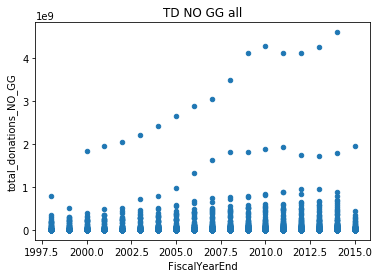

In [22]:
plt = mydata_noi.plot.scatter(x = 'FiscalYearEnd', y = 'total_donations_NO_GG', title= 'TD NO GG all')

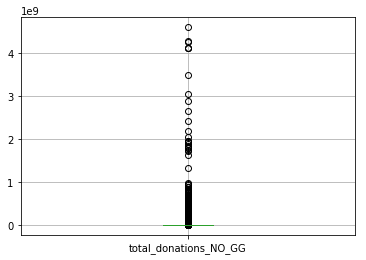

In [23]:
#this shows issue - so many outlier
bp = mydata_noi.boxplot(column='total_donations_NO_GG')

In [20]:
##NOW WILL REMOVE OUTLIERS
#regression
y = mydata_NO.total_donations_NO_GG #NOT INCLUDEING RAISED or GOV GRANNTs BELOW, fundrai, 
x = mydata_NO[['fundraising','PostTreatment*PCG_Treatment','government_grants']]
mod = PanelOLS(y, x, time_effects = True, entity_effects=True) #cant use firm FE - perf collinear to TREATMENT
res = mod.fit(cov_type='robust')  #clustering by EIN???? correct?
print(res)

                            PanelOLS Estimation Summary                            
Dep. Variable:     total_donations_NO_GG   R-squared:                        0.0008
Estimator:                      PanelOLS   R-squared (Between):             -0.0003
No. Observations:                  42785   R-squared (Within):            -8.64e-06
Date:                   Tue, Apr 16 2019   R-squared (Overall):             -0.0001
Time:                           13:27:18   Log-likelihood                -7.137e+05
Cov. Estimator:                   Robust                                           
                                           F-statistic:                      9.9037
Entities:                           6664   P-value                           0.0000
Avg Obs:                          6.4203   Distribution:                 F(3,36101)
Min Obs:                          1.0000                                           
Max Obs:                          18.000   F-statistic (robust):            

In [25]:
mydata_NO[mydata_NO['total_donations_NO_GG'] == 0].shape

(25551, 7)

In [26]:
mydata_NO_noi = mydata_NO.reset_index()

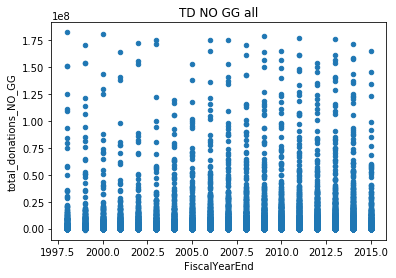

In [27]:
plt = mydata_NO_noi.plot.scatter(x = 'FiscalYearEnd', y = 'total_donations_NO_GG', title= 'TD NO GG all')
#constant dollars?????

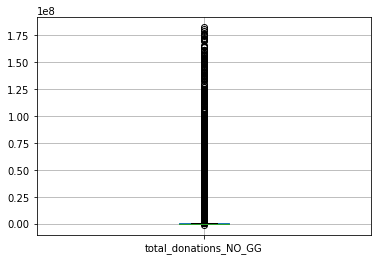

In [28]:
#this shows issue - so many outlier
bp = mydata_NO_noi.boxplot(column='total_donations_NO_GG')

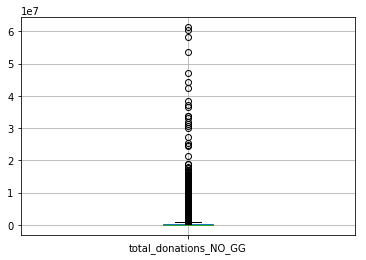

In [29]:
bp = mydata_NO_noi[mydata_NO_noi['PCG_Treatment'] == 1].boxplot(column='total_donations_NO_GG')

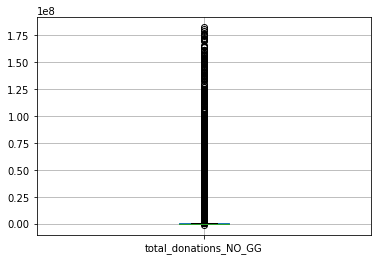

In [30]:
bp = mydata_NO_noi[mydata_NO_noi['PCG_Treatment'] == 0].boxplot(column='total_donations_NO_GG')

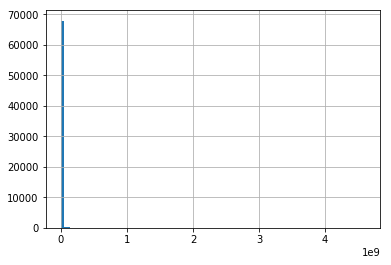

In [31]:
hist = mydata_noi['total_donations_NO_GG'].hist(bins=100)

In [32]:
mydata_NO_noi['total_donations_NO_GG'].describe()

count    6.760800e+04
mean     1.489061e+06
std      8.038424e+06
min     -1.170843e+06
25%      0.000000e+00
50%      3.386750e+04
75%      4.114105e+05
max      1.821374e+08
Name: total_donations_NO_GG, dtype: float64

In [33]:
mydata_noi['total_donations_NO_GG'].describe(percentiles = [.2,.8])

count    6.869100e+04
mean     3.966931e+06
std      6.001701e+07
min     -1.170843e+06
20%      0.000000e+00
50%      3.680600e+04
80%      7.310120e+05
max      4.606417e+09
Name: total_donations_NO_GG, dtype: float64

In [34]:
mydata_noi['PCG_Treatment'].value_counts()

0    64167
1     4524
Name: PCG_Treatment, dtype: int64

In [35]:
mydata_noi['PostTreatment'].value_counts()

0    39711
1    28980
Name: PostTreatment, dtype: int64

In [36]:
#<X and up for total_donations cutoff, number of PCG firms in sample
#1,000,000    2
#  500,000    4
#  100,000    11
#   50,000    13
#   25,000    15
#    1,000    18
#        0    18

In [37]:
df_reg[df_reg['EIN'].isin(df_vert_PCG['EIN'])]['EIN'].nunique()

402

In [38]:
mydata_noi[mydata_noi['PCG_Treatment'] == 1]['EIN'].nunique()

395